# Preprocess MovieLens-20M 

In [1]:
import datetime
import json
import os
import time

import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import scipy.sparse

import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [2]:
DATA_DIR = '/hdd2/dawen/data/ml-20m/'

In [3]:
def timestamp_to_date(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [4]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

In [5]:
# binarize the data (only keep ratings >= 4)
raw_data = raw_data[raw_data['rating'] > 3.5]

In [6]:
# sort the raw data accorindg to timestamp
raw_data = raw_data.sort_index(by=['timestamp'])

In [7]:
raw_data

,userId,movieId,rating,timestamp
4182421,28507,1176,4.0,789652004
18950936,131160,47,5.0,789652009
15688196,108467,57,4.0,822873600
12341186,85252,70,4.0,822873600
14452501,99851,1,4.0,822873600
14452517,99851,58,5.0,822873600
14452516,99851,55,4.0,822873600
14452515,99851,52,4.0,822873600
14452514,99851,50,5.0,822873600
14452513,99851,47,5.0,822873600


In [8]:
tstamp = np.array(raw_data['timestamp'])

In [9]:
print("Time span of the dataset: From %s to %s" % 
      (timestamp_to_date(np.min(tstamp)), timestamp_to_date(np.max(tstamp))))

Time span of the dataset: From 1995-01-09 06:46:44 to 2015-03-31 02:11:28


In [10]:
# apparently the timestamps are ordered, check to make sure

for i in xrange(tstamp.size - 1):
    if tstamp[i] > tstamp[i + 1]:
        print("not ordered")

Confirmed the timestamps are ordered

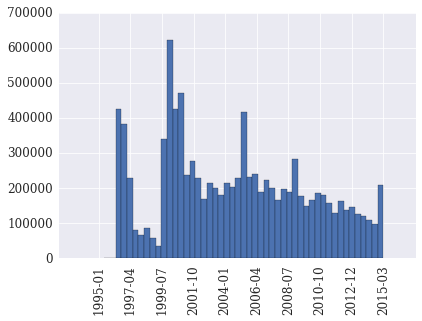

In [11]:
plt.hist(tstamp, bins=50)
xticks = np.linspace(tstamp[0], tstamp[-1], 10)
plt.xticks(xticks, map(lambda x: timestamp_to_date(x)[:7], xticks), rotation=90)
pass

Now we select the data from 1995-01-01 to the last day as the dataset (i.e., all the dataset)

In [12]:
start_t = time.mktime(datetime.datetime.strptime("1995-01-01", "%Y-%m-%d").timetuple())

In [42]:
raw_data = raw_data[raw_data['timestamp'] >= start_t]

Take the first 80% of the data as train and validation set

In [96]:
tr_vd_raw_data = raw_data[:int(0.8 * raw_data.shape[0])]

In [97]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [98]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for songs which were listened to by at least min_sc users. 
    if min_sc > 0:
        songcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(songcount.index[songcount >= min_sc])]
    
    # Only keep the triplets for users who listened to at least min_uc songs
    # After doing this, some of the songs will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and songcount after filtering
    usercount, songcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, songcount

In [99]:
tr_vd_raw_data, user_activity, item_popularity = filter_triplets(tr_vd_raw_data)

In [100]:
sparsity = 1. * tr_vd_raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (tr_vd_raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 7992863 watching events from 111148 users and 11711 movies (sparsity: 0.614%)


In [101]:
unique_uid = user_activity.index
unique_sid = item_popularity.index

In [102]:
song2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [103]:
with open(os.path.join(DATA_DIR, 'pro', 'unique_uid.txt'), 'w') as f:
    for uid in unique_uid:
        f.write('%s\n' % uid)

In [104]:
with open(os.path.join(DATA_DIR, 'pro', 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

Split 12.5% (10% of the total ratings) as validation set

In [105]:
np.random.seed(13579)
n_ratings = tr_vd_raw_data.shape[0]
vad = np.random.choice(n_ratings, size=int(0.125 * n_ratings), replace=False)

In [106]:
vad_idx = np.zeros(n_ratings, dtype=bool)
vad_idx[vad] = True

vad_raw_data = tr_vd_raw_data[vad_idx]
train_raw_data = tr_vd_raw_data[~vad_idx]

Make sure there is no empty users/items

In [107]:
print "There are total of %d unique users in the training set and %d unique users in the entire dataset" % \
(len(pd.unique(train_raw_data['userId'])), len(unique_uid))

There are total of 111148 unique users in the training set and 111148 unique users in the entire dataset


In [108]:
print "There are total of %d unique items in the training set and %d unique items in the entire dataset" % \
(len(pd.unique(train_raw_data['movieId'])), len(unique_sid))

There are total of 11612 unique items in the training set and 11711 unique items in the entire dataset


In [109]:
train_sid = set(pd.unique(train_raw_data['movieId']))

In [110]:
left_sid = list()
for i, sid in enumerate(unique_sid):
    if sid not in train_sid:
        left_sid.append(sid)

In [111]:
move_idx = vad_raw_data['movieId'].isin(left_sid)

In [112]:
train_raw_data = train_raw_data.append(vad_raw_data[move_idx])
vad_raw_data = vad_raw_data[~move_idx]

In [113]:
print "There are total of %d unique items in the training set and %d unique items in the entire dataset" % \
(len(pd.unique(train_raw_data['movieId'])), len(unique_sid))

There are total of 11711 unique items in the training set and 11711 unique items in the entire dataset


For test data, only keep the users and items that appear in the training/validation sets

In [114]:
test_raw_data = raw_data[int(0.8 * len(raw_data)):]

In [115]:
test_raw_data = test_raw_data[test_raw_data['movieId'].isin(unique_sid)]
test_raw_data = test_raw_data[test_raw_data['userId'].isin(unique_uid)]

In [116]:
print len(train_raw_data), len(vad_raw_data), len(test_raw_data)

6993860 999003 207161


Basic data information: what's the timespan for train/test?

In [117]:
train_timestamp = np.asarray(tr_vd_raw_data['timestamp'])
print("train: from %s to %s" % (timestamp_to_date(train_timestamp[0]), 
                                timestamp_to_date(train_timestamp[-1])))

test_timestamp = np.asarray(test_raw_data['timestamp'])
print("test: from %s to %s" % (timestamp_to_date(test_timestamp[0]), 
                               timestamp_to_date(test_timestamp[-1])))

train: from 1995-01-09 06:46:44 to 2009-10-19 06:51:15
test: from 2009-10-19 06:51:53 to 2015-03-31 02:11:28


### Numerize the data into (timestamp, user_index, item_index) format

In [118]:
def numerize(tp):
    uid = map(lambda x: user2id[x], tp['userId'])
    sid = map(lambda x: song2id[x], tp['movieId'])
    tp['uid'] = uid
    tp['sid'] = sid
    return tp[['timestamp', 'uid', 'sid']]

In [119]:
train_data = numerize(train_raw_data)
train_data.to_csv(os.path.join(DATA_DIR, 'pro', 'train.csv'), index=False)

In [120]:
vad_data = numerize(vad_raw_data)
vad_data.to_csv(os.path.join(DATA_DIR, 'pro', 'validation.csv'), index=False)

In [121]:
test_data = numerize(test_raw_data)
test_data.to_csv(os.path.join(DATA_DIR, 'pro', 'test.csv'), index=False)